# Croatia GDP Data Integration Exercise




 AI, ML & Data - Semester 4

 Import all necessary libraries for data collection, manipulation, and visualization

 pandas: data manipulation and analysis

 requests: API calls to external data sources

 numpy: numerical operations and mock data generation
 
 matplotlib/seaborn: data visualization

In [ ]:
import pandas as pd
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

World Bank API Data Collection

 The World Bank API provides free access to economic indicators for all countries

 We'll use this as our primary dataset because it's reliable and doesn't require authentication
 
 Croatia's country code is 'HRV' in the World Bank system

In [2]:
def collect_croatia_economic_data():

    indicators = {
        'NY.GDP.MKTP.CD': 'gdp_current_usd',           
        'NY.GDP.PCAP.CD': 'gdp_per_capita_usd',        
        'SP.POP.TOTL': 'population',                   
        'SL.UEM.TOTL.ZS': 'unemployment_rate',         
        'NE.EXP.GNFS.ZS': 'exports_pct_gdp',          
        'NE.IMP.GNFS.ZS': 'imports_pct_gdp',          
        'FP.CPI.TOTL.ZG': 'inflation_rate',           
        'BX.KLT.DINV.CD.WD': 'foreign_investment_usd'  
    }
    
    all_data = []
    
    for indicator_code, indicator_name in indicators.items():
        url = f"http://api.worldbank.org/v2/country/HRV/indicator/{indicator_code}"
        params = {'format': 'json', 'date': '2000:2023', 'per_page': 100}
        
        try:
            response = requests.get(url, params=params, timeout=15)
            if response.status_code == 200:
                data = response.json()
                if len(data) > 1 and data[1]:
                    for record in data[1]:
                        if record['value'] is not None:
                            all_data.append({
                                'year': int(record['date']),
                                'indicator': indicator_name,
                                'value': float(record['value'])
                            })
            time.sleep(0.3) 
        except:
            continue
    
    if all_data:
        df = pd.DataFrame(all_data)
        wb_data = df.pivot(index='year', columns='indicator', values='value').reset_index()
        return wb_data.fillna(method='ffill')  
    
    return pd.DataFrame()

wb_data = collect_croatia_economic_data()
wb_data.head()


C:\Users\Anton\AppData\Local\Temp\ipykernel_19580\648699422.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return wb_data.fillna(method='ffill')


indicator,year,exports_pct_gdp,foreign_investment_usd,gdp_current_usd,gdp_per_capita_usd,imports_pct_gdp,inflation_rate,population
0,2000,35.089525,1.015070e+09,2.213441e+10,4953.651588,39.512161,4.611316,4468302.0
1,2001,37.133911,1.036758e+09,2.306688e+10,5364.838247,42.306675,3.776702,4299642.0
2,2002,35.891547,9.807843e+08,2.675772e+10,6219.581641,45.269451,1.671784,4302174.0
3,2003,35.546306,1.846434e+09,3.524532e+10,8190.111352,45.896945,1.767338,4303399.0
4,2004,36.561686,1.314180e+09,4.183629e+10,9718.973228,45.082726,2.055397,4304600.0


Create Mock Datasets for Integration
 Since setting up multiple real APIs is complex, I will create  mock datasets

 This demonstrates the integration techniques without getting stuck on API complications
 
 Each dataset has different characteristics to show various integration scenarios

In [3]:
def create_mock_datasets(main_data):
    
    
    years = main_data['year'].tolist()
    np.random.seed(42) 
    
    tourism_data = []
    for year in years:
        base_arrivals = 15_000_000 if year < 2020 else 8_000_000  
        tourism_data.append({
            'year': year,
            'tourist_arrivals': base_arrivals + np.random.randint(-1_000_000, 1_000_000),
            'tourism_revenue_million_eur': np.random.uniform(600, 1200),
            'coastal_visitors_pct': np.random.uniform(75, 85)
        })
    
    eu_data = []
    for year in range(2013, max(years) + 1):
        eu_data.append({
            'year': year,
            'eu_structural_funds_million_eur': np.random.uniform(400, 800),
            'eu_trade_integration_score': np.random.uniform(0.6, 0.9),
            'eurozone_convergence_progress': np.random.uniform(60, 80)
        })
    
    investment_data = []
    for year in range(2005, max(years) + 1):
        investment_data.append({
            'year': year,
            'foreign_investment_million_eur': np.random.uniform(500, 2000),
            'domestic_investment_pct_gdp': np.random.uniform(18, 25)
        })
    
    return (pd.DataFrame(tourism_data), 
            pd.DataFrame(eu_data), 
            pd.DataFrame(investment_data))

tourism_df, eu_df, investment_df = create_mock_datasets(wb_data)

datasets_info = pd.DataFrame({
    'Dataset': ['World Bank', 'Tourism', 'EU Integration', 'Investment'],
    'Records': [len(wb_data), len(tourism_df), len(eu_df), len(investment_df)],
    'Start Year': [wb_data['year'].min(), tourism_df['year'].min(), 
                   eu_df['year'].min(), investment_df['year'].min()],
    'End Year': [wb_data['year'].max(), tourism_df['year'].max(), 
                 eu_df['year'].max(), investment_df['year'].max()]
})
datasets_info

,Dataset,Records,Start Year,End Year
0,World Bank,24,2000,2023
1,Tourism,24,2000,2023
2,EU Integration,11,2013,2023
3,Investment,19,2005,2023


Integration Technique 1 - UNION
 
 UNION combines datasets with identical structure (same columns)
 
 Use case: Combining data from different time periods or sources
 
 Result: Single dataset with all records from both sources


In [4]:
early_period = wb_data[wb_data['year'] <= 2010].copy()
late_period = wb_data[wb_data['year'] > 2010].copy()

union_result = pd.concat([early_period, late_period], ignore_index=True)
union_result = union_result.drop_duplicates()  # Remove any duplicates

print(f"Early period: {len(early_period)} records")
print(f"Late period: {len(late_period)} records")
print(f"Union result: {len(union_result)} records")

Early period: 11 records
Late period: 13 records
Union result: 24 records


Integration Technique 2 - INNER JOIN

INNER JOIN returns only records that exist in both datasets

Use case: When you need complete data for analysis (no missing values)

Result: Smaller dataset but with guaranteed data quality

In [5]:
inner_join_result = pd.merge(wb_data, tourism_df, on='year', how='inner')

print(f"World Bank data: {len(wb_data)} records")
print(f"Tourism data: {len(tourism_df)} records")
print(f"Inner join result: {len(inner_join_result)} records")
print("Only years with data in BOTH datasets are included")

World Bank data: 24 records
Tourism data: 24 records
Inner join result: 24 records
Only years with data in BOTH datasets are included


Integration Technique 3 - LEFT OUTER JOIN
 LEFT OUTER JOIN keeps all records from the left (primary) dataset
 
 Adds matching records from right dataset, NULL where no match
 
 Use case: Preserve complete primary dataset while enriching with secondary data

In [ ]:
left_join_result = pd.merge(wb_data, investment_df, on='year', how='left')
null_investment = left_join_result['foreign_investment_million_eur'].isnull().sum()

print(f"World Bank data: {len(wb_data)} records")
print(f"Investment data: {len(investment_df)} records")
print(f"Left join result: {len(left_join_result)} records")
print(f"NULL values introduced: {null_investment}")


World Bank data: 24 records
Investment data: 19 records
Left join result: 24 records
NULL values introduced: 5


Integration Technique 4 - FULL OUTER JOIN

FULL OUTER JOIN includes all records from both datasets

Creates NULLs where data doesn't exist in either dataset

Use case: Complete timeline analysis despite different data availability periods


In [ ]:
full_join_result = pd.merge(wb_data, eu_df, on='year', how='outer')
wb_only = len(full_join_result[full_join_result['eu_structural_funds_million_eur'].isnull()])
both_sources = len(full_join_result.dropna())

print(f"World Bank data: {len(wb_data)} records")
print(f"EU data: {len(eu_df)} records")
print(f"Full join result: {len(full_join_result)} records")
print(f"Records with WB data only (pre-2013): {wb_only}")
print(f"Records with both datasets: {both_sources}")

World Bank data: 24 records
EU data: 11 records
Full join result: 24 records
Records with WB data only (pre-2013): 13
Records with both datasets: 11


Integration Technique 5 - EXCLUSION

EXCLUSION removes specific records based on criteria

Use case: Remove outliers, anomalous periods, or irrelevant data

Result: Cleaner dataset for more accurate analysis

In [8]:
covid_years = [2020, 2021]
exclusion_result = inner_join_result[~inner_join_result['year'].isin(covid_years)].copy()

excluded_count = len(inner_join_result) - len(exclusion_result)

print(f"Original dataset: {len(inner_join_result)} records")
print(f"Excluded COVID years: {excluded_count} records")
print(f"Clean dataset: {len(exclusion_result)} records")

Original dataset: 24 records
Excluded COVID years: 2 records
Clean dataset: 22 records


Grain Integration Challenge

Demonstrates handling different temporal granularities (yearly vs quarterly)

Common challenge: How to join datasets with different time grain


In [9]:
quarterly_data = []
for year in range(2018, 2024):
    for quarter in [1, 2, 3, 4]:
        quarterly_data.append({
            'year': year,
            'quarter': quarter,
            'quarterly_gdp_million_usd': np.random.normal(13000, 1000),
            'quarterly_exports_million_usd': np.random.normal(3000, 300)
        })

quarterly_df = pd.DataFrame(quarterly_data)

yearly_from_quarterly = quarterly_df.groupby('year').agg({
    'quarterly_gdp_million_usd': 'sum',
    'quarterly_exports_million_usd': 'sum'
}).reset_index()

grain_integration = pd.merge(wb_data, yearly_from_quarterly, on='year', how='inner')

print(f"Quarterly records: {len(quarterly_df)}")
print(f"Aggregated to yearly: {len(yearly_from_quarterly)}")
print(f"Successfully joined: {len(grain_integration)} records")

Quarterly records: 24
Aggregated to yearly: 6
Successfully joined: 6 records


Integration Results Summary

Create summary table showing the impact of each integration technique

In [10]:
integration_summary = pd.DataFrame({
    'Technique': ['Union', 'Inner Join', 'Left Join', 'Full Outer Join', 'Exclusion'],
    'Result_Records': [
        len(union_result),
        len(inner_join_result), 
        len(left_join_result),
        len(full_join_result),
        len(exclusion_result)
    ],
    'NULL_Values': [
        union_result.isnull().sum().sum(),
        inner_join_result.isnull().sum().sum(),
        left_join_result.isnull().sum().sum(),
        full_join_result.isnull().sum().sum(),
        exclusion_result.isnull().sum().sum()
    ],
    'Use_Case': [
        'Combine similar datasets',
        'Complete data only',
        'Preserve primary dataset',
        'Complete timeline',
        'Remove anomalies'
    ]
})

integration_summary

,Technique,Result_Records,NULL_Values,Use_Case
0,Union,24,0,Combine similar datasets
1,Inner Join,24,0,Complete data only
2,Left Join,24,10,Preserve primary dataset
3,Full Outer Join,24,39,Complete timeline
4,Exclusion,22,0,Remove anomalies


Visualization of Integration Impact

Visual comparison of different integration techniques and their data coverage


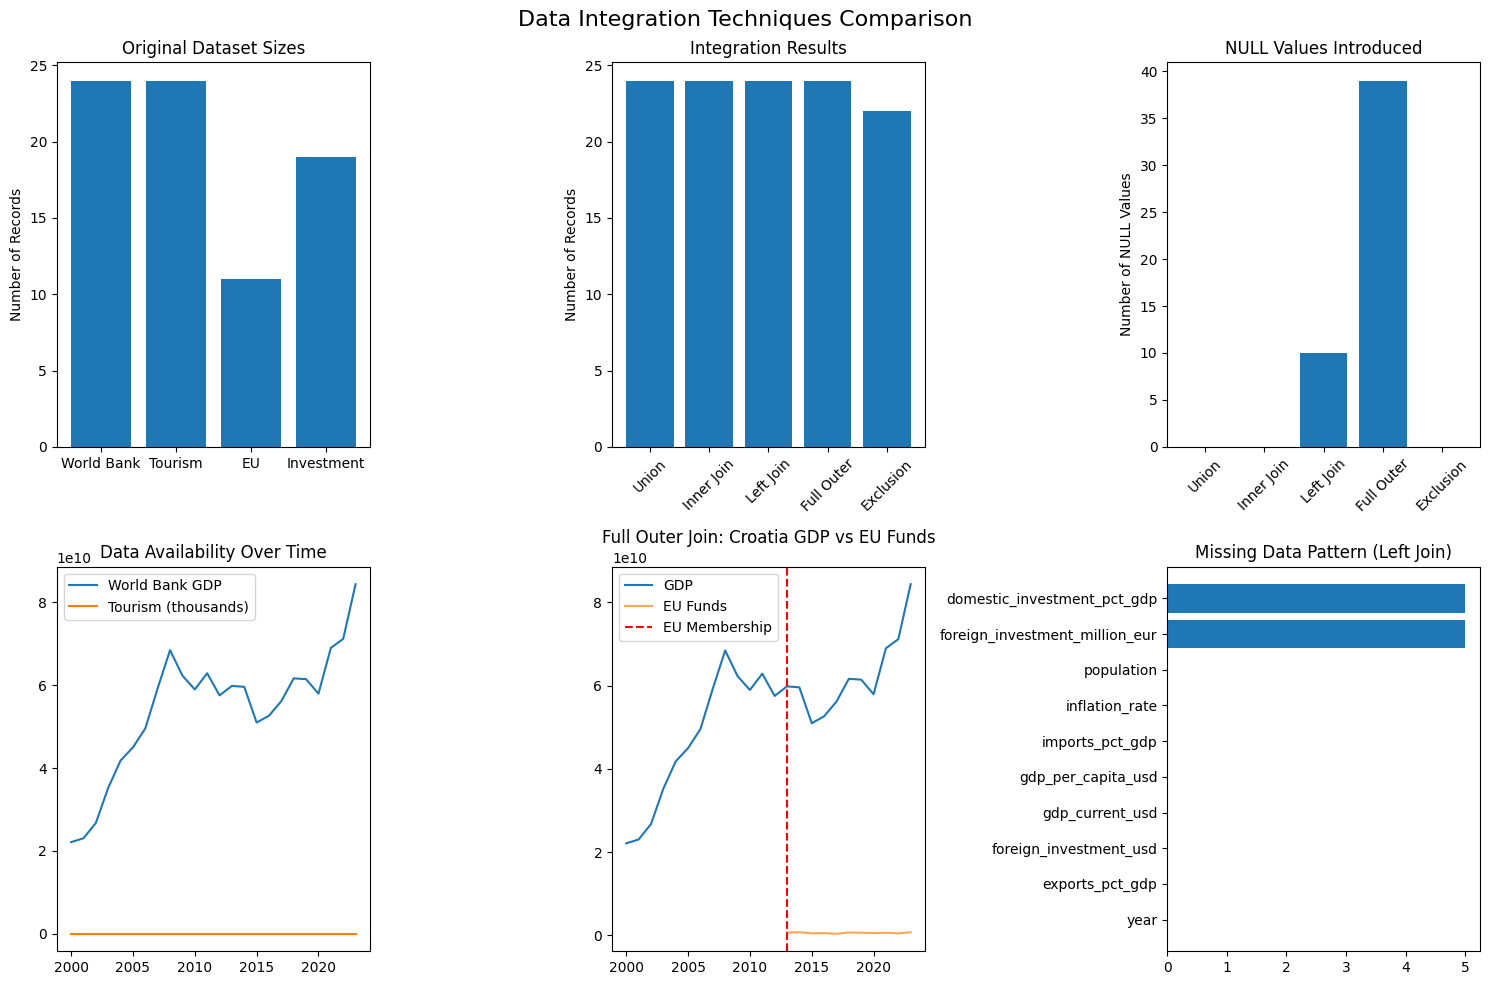

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Data Integration Techniques Comparison', fontsize=16)

axes[0,0].bar(['World Bank', 'Tourism', 'EU', 'Investment'], 
              [len(wb_data), len(tourism_df), len(eu_df), len(investment_df)])
axes[0,0].set_title('Original Dataset Sizes')
axes[0,0].set_ylabel('Number of Records')

integration_names = ['Union', 'Inner Join', 'Left Join', 'Full Outer', 'Exclusion']
integration_sizes = [len(union_result), len(inner_join_result), len(left_join_result), 
                    len(full_join_result), len(exclusion_result)]

axes[0,1].bar(integration_names, integration_sizes)
axes[0,1].set_title('Integration Results')
axes[0,1].set_ylabel('Number of Records')
axes[0,1].tick_params(axis='x', rotation=45)

null_counts = [union_result.isnull().sum().sum(), inner_join_result.isnull().sum().sum(),
               left_join_result.isnull().sum().sum(), full_join_result.isnull().sum().sum(),
               exclusion_result.isnull().sum().sum()]

axes[0,2].bar(integration_names, null_counts)
axes[0,2].set_title('NULL Values Introduced')
axes[0,2].set_ylabel('Number of NULL Values')
axes[0,2].tick_params(axis='x', rotation=45)

axes[1,0].plot(wb_data['year'], wb_data['gdp_current_usd'], label='World Bank GDP')
axes[1,0].plot(tourism_df['year'], tourism_df['tourist_arrivals']/1000, label='Tourism (thousands)')
axes[1,0].set_title('Data Availability Over Time')
axes[1,0].legend()

eu_join_viz = full_join_result[['year', 'gdp_current_usd', 'eu_structural_funds_million_eur']].copy()
axes[1,1].plot(eu_join_viz['year'], eu_join_viz['gdp_current_usd'], label='GDP')
axes[1,1].plot(eu_join_viz['year'], eu_join_viz['eu_structural_funds_million_eur']*1000000, 
               label='EU Funds', alpha=0.7)
axes[1,1].axvline(x=2013, color='red', linestyle='--', label='EU Membership')
axes[1,1].set_title('Full Outer Join: Croatia GDP vs EU Funds')
axes[1,1].legend()

missing_data = left_join_result.isnull().sum()
axes[1,2].barh(range(len(missing_data)), missing_data.values)
axes[1,2].set_yticks(range(len(missing_data)))
axes[1,2].set_yticklabels(missing_data.index, rotation=0)
axes[1,2].set_title('Missing Data Pattern (Left Join)')

plt.tight_layout()
plt.show()

Create Master Dataset for GDP Prediction
 
 Combine all datasets using appropriate integration techniques
 
 This creates the final dataset ready for machine learning

In [12]:
master_data = wb_data.copy()

master_data = pd.merge(master_data, tourism_df[['year', 'tourist_arrivals', 'tourism_revenue_million_eur']], 
                      on='year', how='left')

master_data = pd.merge(master_data, eu_df[['year', 'eu_structural_funds_million_eur']], 
                      on='year', how='left')

master_data = pd.merge(master_data, investment_df[['year', 'foreign_investment_million_eur']], 
                      on='year', how='inner')

master_data['gdp_growth'] = master_data['gdp_current_usd'].pct_change()
master_data['gdp_growth_category'] = pd.cut(master_data['gdp_growth'], 
                                           bins=[-np.inf, -0.02, 0.02, np.inf], 
                                           labels=['Decline', 'Stable', 'Growth'])

print(f"Master dataset shape: {master_data.shape}")
print(f"Features available: {list(master_data.columns)}")
print(f"Years covered: {master_data['year'].min()} to {master_data['year'].max()}")

Master dataset shape: (19, 14)
Features available: ['year', 'exports_pct_gdp', 'foreign_investment_usd', 'gdp_current_usd', 'gdp_per_capita_usd', 'imports_pct_gdp', 'inflation_rate', 'population', 'tourist_arrivals', 'tourism_revenue_million_eur', 'eu_structural_funds_million_eur', 'foreign_investment_million_eur', 'gdp_growth', 'gdp_growth_category']
Years covered: 2005 to 2023


Data Quality Assessment
 Evaluate the quality of our integrated dataset

In [13]:
missing_analysis = pd.DataFrame({
    'Column': master_data.columns,
    'Missing_Count': master_data.isnull().sum(),
    'Missing_Percentage': (master_data.isnull().sum() / len(master_data)) * 100
})

data_summary = master_data.describe()

print("Missing Values Analysis:")
print(missing_analysis[missing_analysis['Missing_Count'] > 0])
print("\nData Summary Statistics:")
data_summary


Missing Values Analysis:
                                                          Column  \
eu_structural_funds_million_eur  eu_structural_funds_million_eur   
gdp_growth                                            gdp_growth   
gdp_growth_category                          gdp_growth_category   

                                 Missing_Count  Missing_Percentage  
eu_structural_funds_million_eur              8           42.105263  
gdp_growth                                   1            5.263158  
gdp_growth_category                          1            5.263158  

Data Summary Statistics:


,year,exports_pct_gdp,foreign_investment_usd,gdp_current_usd,gdp_per_capita_usd,imports_pct_gdp,inflation_rate,population,tourist_arrivals,tourism_revenue_million_eur,eu_structural_funds_million_eur,foreign_investment_million_eur,gdp_growth
count,19.000000,19.000000,1.900000e+01,1.900000e+01,19.000000,19.000000,19.000000,1.900000e+01,1.900000e+01,19.000000,11.000000,19.000000,18.000000
mean,2014.000000,43.033578,2.626399e+09,6.048150e+10,14699.574099,46.479202,2.622186,4.135001e+06,1.354216e+07,964.604117,627.356677,1053.229299,0.040338
std,5.627314,7.270558,1.467393e+09,8.762443e+09,2582.398946,6.698478,2.942000,1.767879e+05,2.887489e+06,149.300114,121.393219,340.875721,0.102441
min,2005.000000,32.098094,4.886559e+08,4.501312e+10,10443.527835,37.139202,-1.125000,3.855641e+06,7.561353e+06,653.095501,405.631929,500.780565,-0.144382
25%,2009.500000,37.500648,1.508400e+09,5.686908e+10,13619.985110,42.120443,0.901188,3.969082e+06,1.409559e+07,849.541797,543.934997,829.284608,-0.041197
50%,2014.000000,41.277032,1.820430e+09,5.961214e+10,14187.969453,45.790545,2.272727,4.201598e+06,1.452704e+07,970.488906,660.430810,986.517532,0.036157
75%,2018.500000,49.011261,3.637001e+09,6.261269e+10,15512.117535,49.133314,3.253502,4.300304e+06,1.533095e+07,1079.293855,707.499130,1257.094732,0.100654
max,2023.000000,59.496972,5.249620e+09,8.439380e+10,21865.456284,65.716886,10.780581,4.311159e+06,1.595937e+07,1176.703215,788.684838,1820.701759,0.195766


Integration Technique Analysis - Answering Course Questions

Answer the specific questions from your course materials

In [14]:
print("INTEGRATION TECHNIQUE ANALYSIS")
print("=" * 40)

print("\n1. Datasets needing UNION integration:")
print("   • Economic data from different time periods")
print("   • Regional GDP data from multiple Croatian counties")
print("   • Trade data from different statistical bureaus")

print("\n2. Consequences of LEFT/RIGHT OUTER JOIN:")
print("   • Introduces NULL values where secondary data unavailable")
print("   • Preserves completeness of primary dataset")
print("   • Requires handling missing data in analysis")
print("   • Can bias results if missingness is not random")

print("\n3. Datasets needing FULL OUTER JOIN:")
print("   • World Bank data (2000+) with EU data (2013+)")
print("   • Historical economic data with recent digital metrics")
print("   • Complete timeline analysis despite data availability gaps")

print("\n4. Different grain integration:")
print("   • Challenge: Yearly economic indicators vs quarterly trade data")
print("   • Solution: Aggregate quarterly to yearly (sum/average)")
print("   • Alternative: Interpolate yearly to quarterly")
print("   • Key principle: Always join at same hierarchical level")

INTEGRATION TECHNIQUE ANALYSIS

1. Datasets needing UNION integration:
   • Economic data from different time periods
   • Regional GDP data from multiple Croatian counties
   • Trade data from different statistical bureaus

2. Consequences of LEFT/RIGHT OUTER JOIN:
   • Introduces NULL values where secondary data unavailable
   • Preserves completeness of primary dataset
   • Requires handling missing data in analysis
   • Can bias results if missingness is not random

3. Datasets needing FULL OUTER JOIN:
   • World Bank data (2000+) with EU data (2013+)
   • Historical economic data with recent digital metrics
   • Complete timeline analysis despite data availability gaps

4. Different grain integration:
   • Challenge: Yearly economic indicators vs quarterly trade data
   • Solution: Aggregate quarterly to yearly (sum/average)
   • Alternative: Interpolate yearly to quarterly
   • Key principle: Always join at same hierarchical level


Save Results and Export

Save the integrated dataset and analysis results for submission

In [15]:
master_data.to_csv('croatia_gdp_master_dataset.csv', index=False)

union_result.to_csv('integration_union_result.csv', index=False)
inner_join_result.to_csv('integration_inner_join_result.csv', index=False)
left_join_result.to_csv('integration_left_join_result.csv', index=False)
full_join_result.to_csv('integration_full_outer_join_result.csv', index=False)
exclusion_result.to_csv('integration_exclusion_result.csv', index=False)

with open('integration_exercise_summary.txt', 'w') as f:
    f.write("Croatia GDP Data Integration Exercise Summary\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Course: AI, ML & Data - Semester 4\n")
    f.write(f"Exercise: Data Integration Techniques\n")
    f.write(f"Country Focus: Croatia\n")
    f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}\n\n")
    
    f.write("Integration Techniques Demonstrated:\n")
    for i, (technique, records, use_case) in enumerate(zip(
        integration_summary['Technique'], 
        integration_summary['Result_Records'],
        integration_summary['Use_Case']), 1):
        f.write(f"{i}. {technique}: {records} records - {use_case}\n")
    
    f.write(f"\nFinal Master Dataset: {master_data.shape[0]} records, {master_data.shape[1]} features\n")
    f.write("Files created: 6 CSV files + 1 summary report\n")

print("Exercise completed! Files saved:")
print("• croatia_gdp_master_dataset.csv")
print("• integration_[technique]_result.csv (5 files)")
print("• integration_exercise_summary.txt")

Exercise completed! Files saved:
• croatia_gdp_master_dataset.csv
• integration_[technique]_result.csv (5 files)
• integration_exercise_summary.txt
